# Regression Used Cars Dataset

https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 


#### **Dependency**

In [1]:
#! pip install lightgbm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations  # For creating combinations of elements
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
import re
from sklearn.preprocessing import StandardScaler
import random

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


#### **Utility Function**

In [2]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype
        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:5] == "float":
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

#### **Load Data**

load csv inside data folder

In [3]:
#kaggle path
df = pd.read_csv('/kaggle/input/craigslist-carstrucks-data/vehicles.csv')
#local path
#df = pd.read_csv("/kaggle/input/vehicles/vehicles.csv")

df=df.convert_dtypes()
df=reduce_mem_usage(df,verbose=True)
#Remove meaningless columns
df.drop(['id','url','region','region_url','title_status',
         'image_url','VIN','size','county','description',
         'state','lat','long'], 
        axis=1, inplace=True)
df.shape
df[0:4]

Memory usage of dataframe is 87.53 MB
Memory usage after optimization is: 87.53 MB
Decreased by 0.00%


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,posting_date
0,6000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,11900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,21000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         426880 non-null  Int64 
 1   year          425675 non-null  Int64 
 2   manufacturer  409234 non-null  string
 3   model         421603 non-null  string
 4   condition     252776 non-null  string
 5   cylinders     249202 non-null  string
 6   fuel          423867 non-null  string
 7   odometer      422480 non-null  Int64 
 8   transmission  424324 non-null  string
 9   drive         296313 non-null  string
 10  type          334022 non-null  string
 11  paint_color   296677 non-null  string
 12  posting_date  426812 non-null  string
dtypes: Int64(3), string(10)
memory usage: 43.6 MB


In [5]:
df[(df['manufacturer']=="ford")]['model'].unique()

<StringArray>
[                  'f-150 xlt',  'ranger supercrew xl pickup',
 'f150 super cab xl pickup 4d',      'f150 supercrew cab xlt',
   'ranger supercab xl pickup',             'f250 super duty',
  'f150 regular cab xl pickup',          'mustang gt premium',
                        'f450',        'expedition xlt sport',
 ...
     'e450 super duty cutaway',   'e-series chassis e-350 sd',
              'f15o fx4 sport',              'f-150 heritage',
         'ranger pickup truck',                  'ranger rmt',
        'f250 crew cab diesel',             'taurus wagon lx',
                   'f150, xlt',              'f150, platinum']
Length: 3875, dtype: string

In [6]:
df.loc[(df['manufacturer']=="audi") & (df['model']=="a6"), "cylinders"].isna().sum()

116

#### **Split dataset** 

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape, df_test.shape)

(341504, 13) (85376, 13)


#### **Data Function**

data preperation

feature engineering

In [8]:
def data_preparation(df:pd.DataFrame)->pd.DataFrame:
    """"
    make data valid
    """
    def keep_first_word(s):
        if pd.notnull(s):  # Use pd.notnull instead of not pd.isnull
            s = str(s).lower()
            s=s.split()[0]
            s = re.sub('[^a-zA-Z0-9]', '', s)
            if(len(s)<3):
                return np.nan
            else:
                return s
        else:
            return np.nan  # Return np.nan for null values

    # filter weird string
    df['model'] = df['model'].apply(keep_first_word)
    md = df['model'].value_counts()
    df = df.dropna(subset=['year', 'odometer', 'manufacturer', 'model'])


    # remove oultier 
    df = df[(df['price']<df['price'].quantile(0.95)) & (df['price']>df['price'].quantile(0.5))]

    # clean the odometer data by computing averge between 0.05 and 0.95
    o1 = df['odometer'].quantile(0.95)
    o2 = df['odometer'].quantile(0.05)
    odometer_avg= df[(df['odometer']<o1) & (df['odometer']>o2)]['odometer'].mean()
    df['odometer'] = df['odometer'].fillna(int(odometer_avg))


    # Take the popular models
    df['model'] = df['model'].apply(lambda s: str(s) if str(s) in md[:50] else "unknown")

    # Take the popular manufacturer
    mf = df['manufacturer'].value_counts()
    df['manufacturer'] = df['manufacturer'].apply(lambda s: str(s) if str(s) in mf[:20] else "unknown")

    # fill data from real world !!!!!!
    temp = df.loc[(df['manufacturer']=="ford") & (df['model']=="f150")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="ford") & (df['model']=="f150"), "cylinders"].fillna("6 cylinders")
    temp = df.loc[(df['manufacturer']=="ford") & (df['model']=="ranger")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="ford") & (df['model']=="ranger"), "cylinders"].fillna(random.choice(["4 cylinders","6 cylinders"]))
    temp = df.loc[(df['manufacturer']=="jeep") & (df['model']=="compass")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="jeep") & (df['model']=="compass"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="jeep") & (df['model']=="wrangler")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="jeep") & (df['model']=="wrangler"), "cylinders"].fillna(random.choice(["4 cylinders","6 cylinders"]))
    temp = df.loc[(df['manufacturer']=="toyota") & (df['model']=="tacoma")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="toyota") & (df['model']=="tacoma"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="cadillac") & (df['model']=="xt4")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="cadillac") & (df['model']=="xt4"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="honda") & (df['model']=="civic")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="honda") & (df['model']=="civic"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="volvo") & (df['model']=="s60")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="volvo") & (df['model']=="s60"), "cylinders"].fillna(random.choice(["4 cylinders","5 cylinders","6 cylinders"]))
    temp = df.loc[(df['manufacturer']=="audi") & (df['model']=="a6")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="audi") & (df['model']=="a6"), "cylinders"].fillna("4 cylinders")
    df['cylinders'] = df['cylinders'].fillna("unknown")


    

    df = df.dropna(subset=['year'])
    
    df = df.fillna('unknown')
    df = df.drop_duplicates()

    # turn nominal data into number
    y = df['price']
    x =df.drop(columns=['price'])
    x=x.convert_dtypes()

    return x,y

def feature_engineering(df:pd.DataFrame)->pd.DataFrame:
    """"
    select useful feature
    """
    #vehicle_age=posting_year - year, get the usage time of this vehicle
    df["posting_date"] = pd.to_datetime(df["posting_date"], utc=True)
    df["posting_year"] = df["posting_date"].dt.year
    df["vehicle_age"] = df["posting_year"] - df["year"]
    
    df.drop(['posting_date','posting_year'], 
        axis=1, inplace=True)
    
    return df


def data_preprocessing(df:pd.DataFrame)->pd.DataFrame:
    x , y =data_preparation(df)
    x=feature_engineering(x)
    return x,y



In [9]:
df_train_x,df_train_y = data_preprocessing(df_train)
df_test_x, df_test_y = data_preprocessing(df_test)

print(df_train_x.isna().sum())
print(df['type'].unique())
print(df_train_x.shape, df_train_y.shape)

year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
vehicle_age     0
dtype: int64
<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string
(131881, 12) (131881,)


In [10]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131881 entries, 240469 to 187915
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          131881 non-null  Int64 
 1   manufacturer  131881 non-null  string
 2   model         131881 non-null  string
 3   condition     131881 non-null  string
 4   cylinders     131881 non-null  string
 5   fuel          131881 non-null  string
 6   odometer      131881 non-null  Int64 
 7   transmission  131881 non-null  string
 8   drive         131881 non-null  string
 9   type          131881 non-null  string
 10  paint_color   131881 non-null  string
 11  vehicle_age   131881 non-null  Int64 
dtypes: Int64(3), string(9)
memory usage: 13.5 MB


In [11]:
df_train_x['model'].unique()

<StringArray>
[   'unknown',       'benz',  'silverado',       '1500',      'super',
     'sierra',     'tundra',       'f150',    'equinox',    'transit',
    'mustang',      'jetta',     'camaro',    'outback',       'f250',
     'tacoma',      'tahoe',      'grand',    'corolla',   'wrangler',
        'mdx',     'malibu',     'accord',   'explorer',    '4runner',
    'elantra',   'corvette',    'charger',      'civic',      'yukon',
       'rav4',      'rogue',       'edge',       '2500',      'prius',
 'challenger',       '3500',     'ranger',     'impala',       'f350',
     'sonata',     'altima', 'expedition',     'escape',      'camry',
        'crv',      'cruze',     'fusion',      'focus',    'odyssey',
      'scion']
Length: 51, dtype: string

In [12]:
#construct label encoder

def encode(categorical_cols,learn_df,df1,df2):
    for col in categorical_cols:
        le = preprocessing.LabelEncoder()
        print(f"Labeling of {col} col")
        learn_df[col]=le.fit_transform(learn_df[col])
        df1[col] = le.transform(df1[col])
        df2[col] = le.transform(df2[col])
    return learn_df,df1, df2

def scale(learn_df,df1,df2):
    cols =learn_df.columns.values.tolist()

    scaler = StandardScaler().set_output(transform="pandas")
    scaler.fit(learn_df)
    df1 = scaler.transform(df1)
    df2 = scaler.transform(df2)
    return df1, df2

cols = df_test_x.columns.values.tolist()
categorical_cols = []
for col in cols:
    if df_test_x[col].dtype == "string":
        categorical_cols.append(col)

print(f"{categorical_cols}")
# get the encoder 
tempPd = pd.concat([df_train_x,df_test_x],ignore_index=True)
tempPd,df_train_x,df_test_x = encode(categorical_cols,tempPd,df_train_x, df_test_x)
df_train_x,df_test_x = scale(tempPd,df_train_x, df_test_x)
#convert
del tempPd

['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
Labeling of manufacturer col
Labeling of model col
Labeling of condition col
Labeling of cylinders col
Labeling of fuel col
Labeling of transmission col
Labeling of drive col
Labeling of type col
Labeling of paint_color col


In [13]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131881 entries, 240469 to 187915
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          131881 non-null  float64
 1   manufacturer  131881 non-null  float64
 2   model         131881 non-null  float64
 3   condition     131881 non-null  float64
 4   cylinders     131881 non-null  float64
 5   fuel          131881 non-null  float64
 6   odometer      131881 non-null  float64
 7   transmission  131881 non-null  float64
 8   drive         131881 non-null  float64
 9   type          131881 non-null  float64
 10  paint_color   131881 non-null  float64
 11  vehicle_age   131881 non-null  float64
dtypes: float64(12)
memory usage: 13.1 MB


In [14]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33091 entries, 264502 to 50359
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          33091 non-null  float64
 1   manufacturer  33091 non-null  float64
 2   model         33091 non-null  float64
 3   condition     33091 non-null  float64
 4   cylinders     33091 non-null  float64
 5   fuel          33091 non-null  float64
 6   odometer      33091 non-null  float64
 7   transmission  33091 non-null  float64
 8   drive         33091 non-null  float64
 9   type          33091 non-null  float64
 10  paint_color   33091 non-null  float64
 11  vehicle_age   33091 non-null  float64
dtypes: float64(12)
memory usage: 3.3 MB


#### **Training and Evaluation**

## LGBM

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

best parms: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 1500, 'num_leaves': 192, 'subsample': 1}
Root Mean Squared Error: 3852.999261052602
Mean Absolute Error: 2396.796906121915
R-squared: 0.7770918494927712


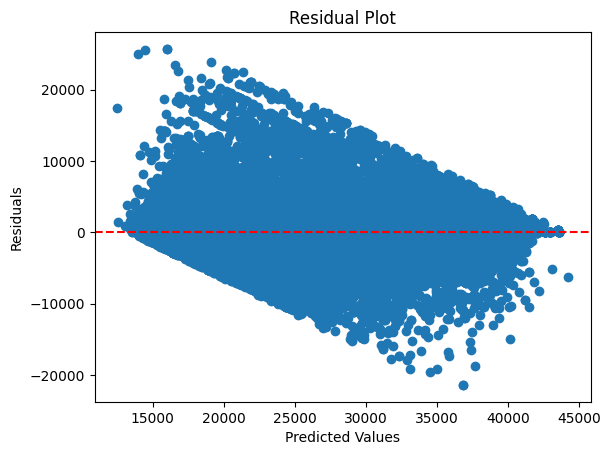

In [15]:
# training
numJobs=3
cv=3
paramgrid={
                "n_estimators": [1500],
                "num_leaves": [192],
                "subsample": [1],
                "colsample_bytree":[0.8],
                "learning_rate": [0.1],
            }

model = lgb.LGBMRegressor(n_estimators= 500,random_state=4487,objective='mae',learning_rate=0.05,importance_type= "gain",device="gpu",verbosity=-1)
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)

#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## CatBoost

Fitting 3 folds for each of 1 candidates, totalling 3 fits
best parms: {'iterations': 1500, 'learning_rate': 0.1, 'random_state': 4487}
Root Mean Squared Error: 4404.3294264139795
Mean Absolute Error: 3049.892311956222
R-squared: 0.708735411421864


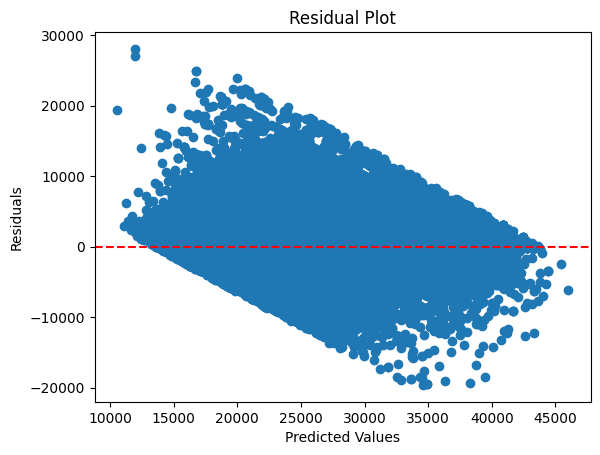

In [16]:
import catboost as cat
# training
numJobs=3
cv=3
paramgrid={
    'iterations':[1500],
    'random_state': [4487],
    "learning_rate": [0.1],
}
model = cat.CatBoostRegressor(objective='MAE',verbose=False)
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)


#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## XGB

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:07:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:07:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

best parms: {'eval_metric': 'mae', 'learning_rate': 0.1, 'n_estimators': 1500, 'random_state': 4487}
Root Mean Squared Error: 3359.40696112633
Mean Absolute Error: 2231.753634951488
R-squared: 0.8305454117107516


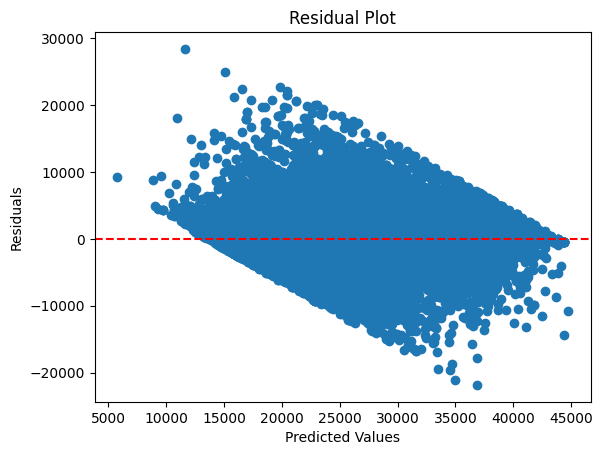

In [17]:
import xgboost as xgb
paramgrid={
    'n_estimators':[1500],
    'eval_metric': ['mae'],
    'random_state': [4487],
    'learning_rate': [0.1],
}
model=xgb.XGBRegressor(n_estimators = 500,tree_method = "hist", device = "cuda", eval_metric = 'mae')
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)
#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Ensemble

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 131881, number of used features: 12
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (1.51 MB) transferred to GPU in 0.002241 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 24590.000000
Root Mean Squared Error: 3720.8883526149643
Mean Absolute Error: 2501.903462237867
R-squared: 0.7921158514832239


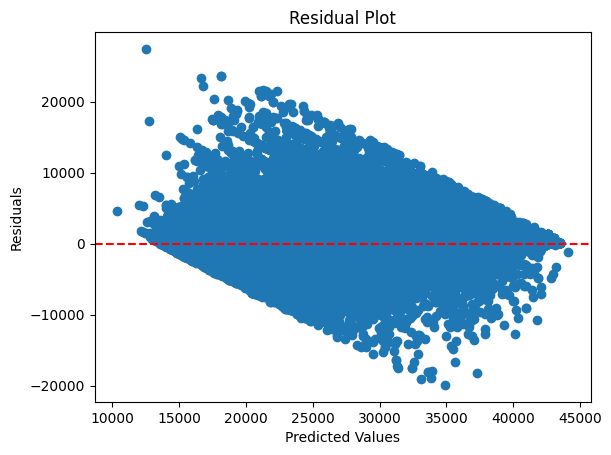

In [18]:
from sklearn.ensemble import VotingRegressor

lgbr = lgb.LGBMRegressor(n_estimators= 1500,random_state=4487,objective='mae',learning_rate=0.1,num_leaves=192,importance_type= "gain",device="gpu")
catr = cat.CatBoostRegressor(iterations=1500,random_state=4487,learning_rate=0.1,objective='MAE',verbose=False)
xgbr = xgb.XGBRegressor(n_estimators = 1500,random_state=4487,learning_rate=0.1,tree_method = "hist", device = "cuda", eval_metric = 'mae')
vr = VotingRegressor([('lgbr', lgbr), ('catr', catr), ('xgbr', xgbr)])
vr.fit(df_train_x, df_train_y)
y_pred = vr.predict(df_test_x)

# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Random Forest

Root Mean Squared Error: 3998.0696897102353
Mean Absolute Error: 2838.703371813786
R-squared: 0.759990287349309


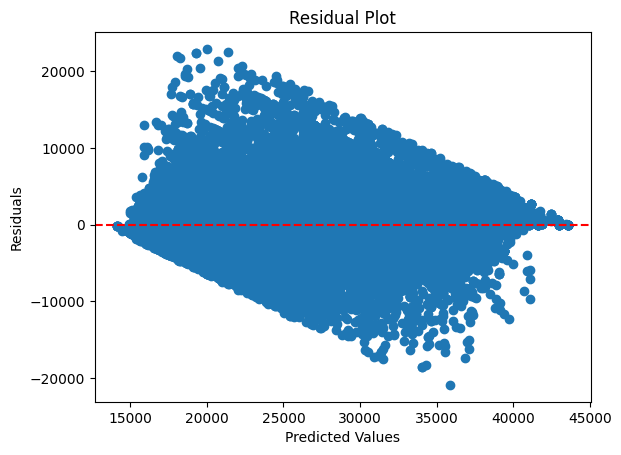

In [22]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor(n_estimators=1500,max_depth=13,random_state=4487,n_jobs=-1)
regr.fit(df_train_x, df_train_y)
y_pred = regr.predict(df_test_x)


# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
